In [1]:
%cd ../../../

/Users/macos/Uni/1st_year/period_3/DSProj


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm

In [3]:
plt.style.use('seaborn-v0_8')
plt.rcParams.update({'font.size': 8})

## 0. Load data

In [4]:
path = "/Users/macos/Uni/1st_year/period_3/DSProj/data/AllSites_SiteOccurrences_AllGenera_26.1.24.csv"

df = pd.read_csv(path)

df.head()

,SITE_NAME,Equus,Coelodonta,Bos,Gazella,Ursus,Vulpes,Cervus,Canis,Sus,...,Total_Gen_Count,Large_GenCount,Small_GenCount,smallperlarge,smallprop,Herb_GenCount,Nonherb_GenCount,DietRatio,HerbProp,mid_age
0,Aba Zawei,1,1,1,1,0,0,0,0,0,...,4,4,0,0.0,0.000000,4,0,NaN,1.000000,0.0265
1,Abric Romani,1,0,1,0,1,1,1,1,1,...,12,12,0,0.0,0.000000,6,5,1.2,0.500000,0.0550
2,Acheng_Jiaojie,0,0,0,0,0,0,1,0,0,...,7,5,2,0.4,0.285714,5,2,2.5,0.714286,0.2100
3,Adler cave,1,0,0,0,0,1,0,1,0,...,10,5,5,1.0,0.500000,6,4,1.5,0.600000,0.0275
4,Adyrgan,1,0,0,1,0,0,0,0,0,...,11,5,6,1.2,0.545455,11,0,NaN,1.000000,2.2000


In [5]:
path_embd_site = "code/visualization/embd_site_mf.np.npy"
path_embd_species = "code/visualization/embd_species_mf.np.npy"
path_enc_site = "code/visualization/ordinal_enc_site_mf.np.npy"
path_enc_species = "code/visualization/ordinal_enc_species_mf.np.npy"

emb_site = np.load(path_embd_site)
emb_species = np.load(path_embd_species)
enc_site = np.load(path_enc_site, allow_pickle=True)
enc_species = np.load(path_enc_species, allow_pickle=True)

In [6]:
enc_species = enc_species.squeeze()
enc_site = enc_site.squeeze()

In [7]:
specidict_species_embd = {
    species: emb for species, emb in zip(enc_species, emb_species)
}

specidict_species_embd['Equus']

array([-0.6024582 , -0.17209442, -0.88206327,  0.2515482 , -0.9718773 ,
        0.942542  , -0.47676274, -1.043077  ,  0.21375427,  0.66247857,
       -0.39991286, -0.20432994,  0.4799328 , -0.88079673,  0.529288  ,
        0.403689  ,  0.5744591 , -1.3953732 ,  2.2029588 ,  1.4625548 ,
       -0.5329598 ,  0.38212925,  0.51151663,  0.67590034,  0.9829826 ,
       -0.523997  , -0.5824796 ,  0.06244349, -0.5188971 ,  0.32071757,
       -0.9634313 , -0.08950552, -0.160659  , -0.30243152,  0.29806143,
       -0.38844678,  0.00229704,  1.2085063 , -0.37325615, -0.5277497 ,
        1.7293639 , -0.27959004,  0.35775962, -0.3196511 ,  0.55379546,
       -1.3178645 , -0.7488011 , -0.4749589 ,  0.79523826,  0.9699398 ,
        0.83651245, -0.3160859 , -1.301971  , -0.92213386,  0.463068  ,
       -0.24124621,  0.59597677,  1.3608215 ,  1.0651474 ,  0.55439454,
        0.22865285,  0.43462545,  0.3180721 , -0.84774804], dtype=float32)

## 2. Start validating

In [8]:
emb_species_normed = emb_species / np.clip(np.linalg.norm(emb_species, axis=1)[:, None], a_max=10, a_min=1e-6)

In [9]:
N = 15
N_SITES = 10

In [13]:
results = []

for species in tqdm(np.random.choice(enc_species.squeeze(), 10, replace=False)):
    emb = specidict_species_embd[species]

    # Calculate cosine sim
    emb = emb / np.clip(np.linalg.norm(emb), a_min=1e-6, a_max=10)
    sim = emb_species_normed @ emb[:, None]

    # Get top N similar species
    idx_top = np.argpartition(sim.squeeze(), -N)[-N:]
    species_sim = enc_species[idx_top]

    # Sample several sites to calculate co-occurence
    sites_available = df[df[species] == 1][['SITE_NAME', species]]['SITE_NAME']
    if len(sites_available) <= N_SITES:
        sites_sample = sites_available
    else:
        sites_sample = sites_available.sample(N_SITES, replace=False)
    results.extend(df[df['SITE_NAME'].isin(sites_sample)][species_sim].mean(axis=1).tolist())


  0%|          | 0/10 [00:00<?, ?it/s]

In [21]:
mse_knn = np.square(1 - np.array(results, dtype=np.float32)).mean()

mse_knn

0.7911112

<Axes: xlabel='mse', ylabel='model'>

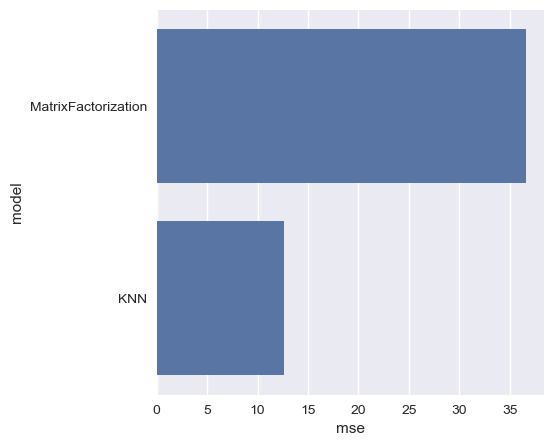

In [28]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

df_mse = pd.DataFrame({'model': ['MatrixFactorization', 'KNN'], 'mse': [36.58792802025971, mse_knn * 16]})
sns.barplot(df_mse, y='model', x='mse', ax=ax)